In [ ]:
!pip install python-chess

In [1]:
import random
import chess
from IPython.display import SVG, display
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt

In [2]:
def play_random(fen):
    # We can create a python-chess board instance from the FEN string like this:
    board = chess.Board(fen=fen)
    
    # And then randomly pick a legal move:
    move = random.choice(list(board.legal_moves))

    # Now we turn our move into a string, return it and call it a day!
    return str(move)

In [3]:
def isDiff_from_last(cur, las):
    cur =str(cur)
    las =str(las)
    # print("cur: ", cur[0:2], "las: ", las[2:4])
    # print("result: ", cur[0:2] != las[2:4])
    if cur[0:2] == las[2:4] and cur[2:4] == las[0:2]:
        return False
    return True

In [4]:
svgarr = []
# Our play function accepts whatever strategy our AI is using, like play_random from above
def play_game(ai_function):
    board = chess.Board()
    l_user_move = None
    l_ai_move = None
    turn = 0
    while board.outcome() is None:
        # We print out the board as an SVG
        svgarr.append((SVG(board._repr_svg_())))
        

        # If it's white's turn, we have the user play
        if board.turn == chess.WHITE:
            # user_move = input('Your move: ')
            # if user_move == 'quit':
            #     break
            # # The move a user puts in isn't a valid move, we keep prompting them for a valid move
            # while user_move not in [str(move) for move in board.legal_moves]:
            #     print('That wasn\'t a valid move. Please enter a move in Standard Algebraic Notation')
            #     user_move = input('Your move: ')
            user_move = play_random(board.fen())
            # while not isDiff_from_last(user_move, l_user_move):
            #     #print(f'cur: {user_move}, las: {l_user_move}')
            #     user_move = play_random(board.fen())
            print(f'{turn}.user move: {user_move}')
            board.push_san(user_move)
            l_user_move = user_move

        # If it's black's turn, we have the AI play
        elif board.turn == chess.BLACK:
            ai_move = ai_function(board.fen())
            # while not isDiff_from_last(ai_move, l_ai_move):
            #     #print(f'cur: {ai_move}, las: {l_ai_move}')
            #     ai_move = ai_function(board.fen())
            print(f'{turn}.AI move: {ai_move}')
            board.push_san(ai_move)
            l_ai_move = ai_move
        turn+=1
        #print(turn)
    print(board.outcome())

In [5]:
# Now lets use that function to encode our entire board

def encode_board(board):
    # first lets turn the board into a string
    board_str = str(board)
    # then lets remove all the spaces
    material_dict = {
        'p': -1,
        'b': -3.5,
        'n': -3,
        'r': -5,
        'q': -9,
        'k': -4,
        'K': 4,
        '.': 0,
        'P': 10,
        'B': 3.5,
        'N': 3,
        'R': 5,
        'Q': 9,
    }
    board_str = board_str.replace(' ', '')
    board_list = []
    for row in board_str.split('\n'):
        row_list = []
        for piece in row:
            # print(piece)
            row_list.append(material_dict.get(piece))
        board_list.append(row_list)
    return np.array(board_list)

# Let's test on the starting board
encode_board(chess.Board())

array([[-5. , -3. , -3.5, -9. , -4. , -3.5, -3. , -5. ],
       [-1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [10. , 10. , 10. , 10. , 10. , 10. , 10. , 10. ],
       [ 5. ,  3. ,  3.5,  9. ,  4. ,  3.5,  3. ,  5. ]])

In [6]:
# Great! We can now use this function to get any board state ready for our model!
# We'll use pandas to pull in all our training data

train_df = pd.read_csv('data/train.csv', index_col='id')

# We'll only use the first 10000 examples so things run fast,
# but you'll get better performance if you remove this line
train_df = train_df[:55000]

# We'll also grab the last 1000 examples as a validation set
val_df = train_df[-1000:]
train_df.head()

board  black_score  \
id                                                                      
80091               6R1/8/5K2/8/5k2/8/8/2r5 w - - 89 118          0.0   
18578  r1bn1rk1/1p2b1p1/1q2p2p/p2p1p1n/P2P3P/2PB1N2/1...       -131.0   
11580  r2qkb1r/2p2pp1/p1n2nP1/1p1p3p/P7/1Q5b/1PP1PPB1...       -490.0   
72805                  8/4kp2/R6p/8/4K3/8/8/8 b - - 7 85       -574.0   
74310                 8/8/k7/4R3/8/6K1/8/1r6 w - - 99 90          0.0   

      best_move  
id               
80091      g8d8  
18578      f3e5  
11580      g6f7  
72805      h6h5  
74310      e5e6

In [7]:
def encode_fen_string(fen_str):
    board = chess.Board(fen=fen_str)
    return encode_board(board)

# We'll stack all our encoded boards into a single numpy array
X_train = np.stack(train_df['board'].apply(encode_fen_string))
y_train = train_df['black_score']


X_val = np.stack(val_df['board'].apply(encode_fen_string))
y_val = val_df['black_score']

In [8]:
print(X_train.shape)
print(y_train.shape)

(55000, 8, 8)
(55000,)


In [9]:
# With the Keras Sequential model we can stack neural network layers together

def create_model():
    model = Sequential()
    model.add(Flatten(input_shape=(8, 8)))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.summary()
    return model

model = create_model()


/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,225 (516.50 KB)

 Trainable params: 132,225 (516.50 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer='adam',loss='mean_squared_error')
# To test things out, let's train for 20 epochs and see how our model is doing
history = model.fit(X_train,y_train,epochs=50,validation_data=(X_val, y_val))

Epoch 1/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 140234.2344 - val_loss: 97715.0078
Epoch 2/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 96325.0156 - val_loss: 74688.3672
Epoch 3/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 83001.2031 - val_loss: 64014.7656
Epoch 4/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 70509.9453 - val_loss: 58880.8750
Epoch 5/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 65834.6094 - val_loss: 53655.8242
Epoch 6/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 63768.6367 - val_loss: 50473.5664
Epoch 7/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 55105.6172 - val_loss: 46053.0469
Epoch 8/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 51387.2422 - val_loss: 42413.9492
Epoch 9/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 56272.1992 - val_loss: 37661.6992
Epoch 10/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 52700.1289 - val_loss: 37986.6719
Epoch 11/50
1719/1719 ━━━━━━━━━━━━━━━━

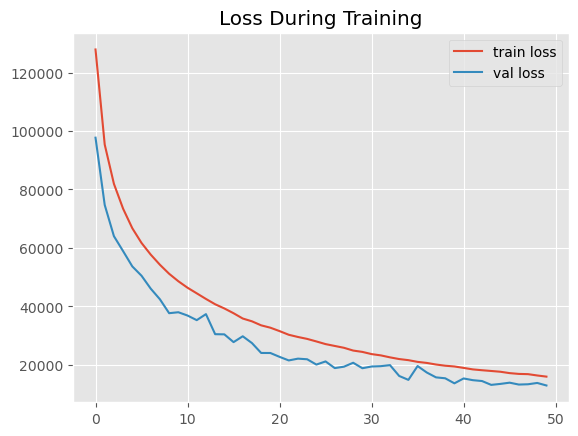

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


array([[ 469.24002 ],
       [-321.31656 ],
       [-358.4691  ],
       [ -43.834274],
       [-491.97824 ],
       [ 426.48627 ],
       [  58.57541 ],
       [  76.20162 ],
       [ 211.09117 ],
       [-158.11249 ]], dtype=float32)

In [12]:
# Lets plot the history of our training session to see how things progressed over time
plt.style.use('ggplot')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss During Training')
plt.show()

model.predict(X_val[:10])

In [13]:
def play_nn(fen, player='b'):
    # We can create a python-chess board instance from the FEN string like this:
    board = chess.Board(fen=fen)

    # And then evaluate all legal moves
    best_move = ''
    worst_move = ''
    minScore = float('inf')
    maxScore = float('-inf')

    moves = []
    for move in board.legal_moves:
        # For each move, we'll make a copy of the board and try that move out
        candidate_board = board.copy()
        candidate_board.push(move)
        input_vector = encode_board(str(candidate_board)).astype(np.int32)
        
        # This is where our model gets to shine! It tells us how good the resultant score board is for black:
        score = model.predict(np.expand_dims(input_vector, axis=0), verbose=0)[0][0]
        if score > maxScore:
            best_move = move
            maxScore = score
        elif score < minScore:
            worst_move = move
            minScore = score
        # moves.append((score, move))
        # if show_move_evaluations:
        #     print(f'{move}: {score}')
    
    # By default sorting our moves will put the lowest scores at the top.
    # This would give us the right answer if we were playing as white,
    # but if we're playing as black we want to reverse things (then grab the first move):
    
    # if(player=='b'):
    #     return str(worst_move)
    # Now we turn our move into a string, return it and call it a day!
    return str(best_move)

In [21]:
### Now that we have a policy, we can play against it!
svgarr = []
play_game(play_nn)


0.user move: d2d3
1.AI move: g8f6
2.user move: f2f3
3.AI move: c7c5
4.user move: g2g4
5.AI move: f6g4
6.user move: b2b3
7.AI move: h8g8
8.user move: c1g5
9.AI move: d7d5
10.user move: g5f6
11.AI move: e7f6
12.user move: h2h3
13.AI move: g8h8
14.user move: b1a3
15.AI move: d5d4
16.user move: h3g4
17.AI move: c8g4
18.user move: e2e4
19.AI move: d4e3
20.user move: h1h4
21.AI move: d8c8
22.user move: f1g2
23.AI move: e8d8
24.user move: a1c1
25.AI move: c5c4
26.user move: h4h1
27.AI move: c4d3
28.user move: c2c4
29.AI move: c8c4
30.user move: d1e2
31.AI move: h7h5
32.user move: b3c4
33.AI move: b8c6
34.user move: e1f1
35.AI move: d8d7
36.user move: e2b2
37.AI move: d3d2
38.user move: g1h3
39.AI move: d2d1q
40.user move: c1d1
41.AI move: c6d4
42.user move: b2b7
43.AI move: d7e8
44.user move: d1b1
45.AI move: h8h7
46.user move: b7b6
47.AI move: d4f3
48.user move: b6e3
49.AI move: e8d7
50.user move: b1b4
51.AI move: f3g5
52.user move: e3e8
53.AI move: d7c7
54.user move: b4b5
55.AI move: g4d1
5

In [15]:
import os
from IPython.display import SVG
import cairosvg
#os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/Cellar/ffmpeg/7.0_1"
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/Cellar/ffmpeg/7.0_1/bin/ffmpeg"
from moviepy.editor import ImageSequenceClip
from PIL import Image

In [22]:
# List of IPython.display.SVG objects
# svg_objects = [
#     SVG('<svg xmlns="http://www.w3.org/2000/svg" width="100" height="100"><circle cx="50" cy="50" r="40" stroke="black" stroke-width="3" fill="red" /></svg>'),
#     SVG('<svg xmlns="http://www.w3.org/2000/svg" width="100" height="100"><rect width="100" height="100" style="fill:blue;stroke-width:3;stroke:black" /></svg>'),
#     # Add more SVG objects as needed
# ]

# Define paths
svg_folder = "svg_folder"
png_folder = "png_folder"
output_video = "output.mp4"

# Ensure the folders exist
os.makedirs(svg_folder, exist_ok=True)
os.makedirs(png_folder, exist_ok=True)

# Step 1: Save SVG data to files
def save_svg(svg_obj, path):
    with open(path, 'w') as file:
        file.write(svg_obj.data)

for i, svg_obj in enumerate(svgarr):
    svg_path = os.path.join(svg_folder, f'image{i:04d}.svg')
    save_svg(svg_obj, svg_path)

# Step 2: Convert SVG to PNG with uniform size
def convert_svg_to_png(svg_path, png_path, width, height):
    cairosvg.svg2png(url=svg_path, write_to=png_path, output_width=width, output_height=height)

# Determine desired width and height for the PNGs
desired_width = 1024  # Change this to your desired width
desired_height = 1024  # Change this to your desired height

svg_files = sorted([f for f in os.listdir(svg_folder) if f.endswith('.svg')])

for svg_file in svg_files:
    svg_path = os.path.join(svg_folder, svg_file)
    png_path = os.path.join(png_folder, f'{os.path.splitext(svg_file)[0]}.png')
    convert_svg_to_png(svg_path, png_path, desired_width, desired_height)

# Step 3: Create a video from PNG files
png_files = sorted([os.path.join(png_folder, f) for f in os.listdir(png_folder) if f.endswith('.png')])

clip = ImageSequenceClip(png_files, fps=7)
clip.write_videofile(output_video, codec='libx264')

print(f"Video created: {output_video}")


Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4
Video created: output.mp4
